In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
        
players_filename = "data/raw/players.csv"
scouting_filename = "data/raw/PFFScoutingData.csv"
tracking_2018_filename = "data/raw/tracking2018.csv"
tracking_2019_filename = "data/raw/tracking2019.csv"
tracking_2020_filename = "data/raw/tracking2020.csv"
games_filename = "data/raw/games.csv"
plays_filename = "data/raw/plays.csv"

# players = pd.read_csv(players_filename)
# games = pd.read_csv(games_filename)
# scouting = pd.read_csv(scouting_filename)
# plays = pd.read_csv(plays_filename)
tracking_2018 = pd.read_csv(tracking_2018_filename)
tracking_2019 = pd.read_csv(tracking_2019_filename)
tracking_2020 = pd.read_csv(tracking_2020_filename)

# This should take about a minute to run

## Function To Create a Football Field

Adapted From: [Big Data Bowl Basic EDA](https://www.kaggle.com/werooring/nfl-big-data-bowl-basic-eda-for-beginner?scriptVersionId=76703169&cellId=81)


In [2]:
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [12, 8]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#3f995b', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax

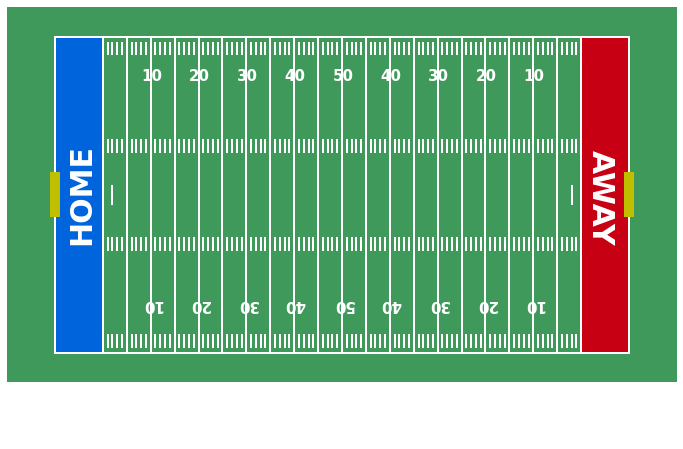

In [3]:
# These are standard dimensions of the football field with respect to the data. (See Big Data Bowl Data Section)
# The field is 120 x 53.3 including the endzones. This code does not include the endzones in its width metric for the input, so it just requires 100.
fig, ax = drawPitch(100, 53.3)

In [18]:
games_ids = {}
games_tracking_2018 = tracking_2018.groupby(by=["gameId"])
for game, data in games_tracking_2018:
    games_ids[game] = list(set(data.playId.tolist()))

In [19]:
def extract_one_game(game_id, play_id, df):
    game = df[(df.gameId == game_id) & (df.playId == play_id)]
    home = {}
    away = {}
    balls = []
    
    players = game.sort_values(['frameId'], ascending=True).groupby('nflId')
    for id, dx in players:
        jerseyNumber = int(dx.jerseyNumber.iloc[0])
        if dx.team.iloc[0] == "home":
            home[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))
        elif dx.team.iloc[0] == "away":
            away[jerseyNumber] = list(zip(dx.x.tolist(), dx.y.tolist()))


    ball_df = game.sort_values(['frameId'], ascending=True) 
    ball_df = ball_df[ball_df.team == "football"]
    balls = list(zip(ball_df.x.tolist(), ball_df.y.tolist()))
    return home, away, balls

In [20]:
from matplotlib import animation
from IPython.display import HTML
def animate_one_play(game_id, play_id, df):
    fig, ax = drawPitch(100, 53.3)
    
    home, away, balls = extract_one_game(game_id, play_id, df)

    team_left, = ax.plot([], [], 'o', markersize=20, markerfacecolor="r", markeredgewidth=2, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=20, markerfacecolor="b", markeredgewidth=2, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=10, markerfacecolor="black", markeredgewidth=2, markeredgecolor="white", zorder=7)
    drawings = [team_left, team_right, ball]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        return drawings

    def draw_teams(i):
        X = []
        Y = []
        for k, v in home.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for k, v in away.items():
            x, y = v[i]
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)

    def animate(i):
        draw_teams(i)
        
        x, y = balls[i]
        ball.set_data([x, y])
        return drawings
    
    # !May take a while!
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(balls), interval=100, blit=True)
    return HTML(anim.to_html5_video())

## Now we can animate any play by passing in the game_id, play_id and dataframe

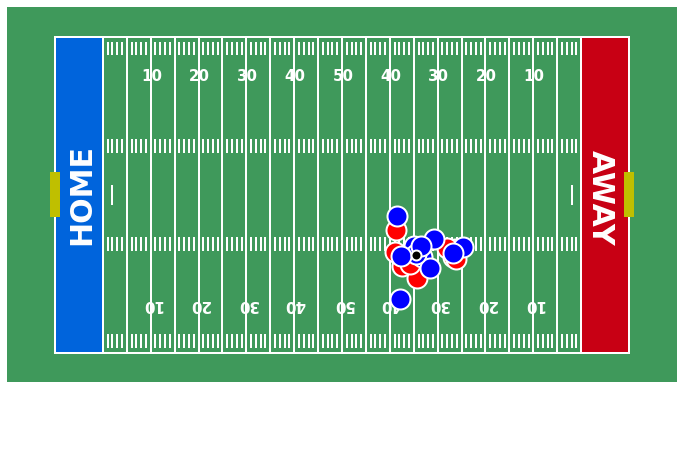

In [21]:
animate_one_play(2018123000, 36, tracking_2018)